In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01')
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468262,72.528582,71.223259,71.476600,135480400
2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2020-01-06,72.335564,72.374169,70.634547,70.885479,118387200
2020-01-07,71.995338,72.600945,71.775773,72.345189,108872000
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200
...,...,...,...,...,...
2025-12-26,273.399994,275.369995,272.859985,274.160004,21521800
2025-12-29,273.760010,274.359985,272.350006,272.690002,23715200


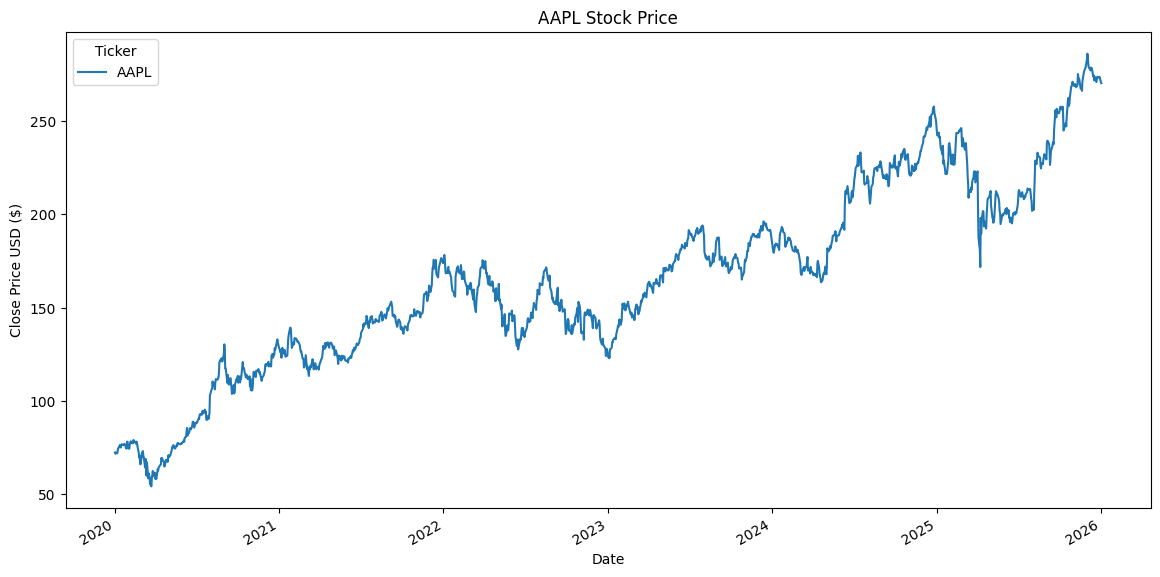

In [5]:
df.Close.plot(title='AAPL Stock Price', figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

In [6]:
scalar = StandardScaler()
df['Close'] = scalar.fit_transform(df[['Close']])
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.859801
2020-01-03,-1.873960
2020-01-06,-1.862468
2020-01-07,-1.869305
2020-01-08,-1.846030
...,...
2025-12-26,2.178235
2025-12-29,2.185470
2025-12-30,2.171804


In [7]:
seq_length = 30
data = []
for i in range(len(df) - seq_length):
    data.append(df.Close[i: i + seq_length])

data = np.array(data)
data

array([[[-1.85980084],
        [-1.87395975],
        [-1.86246762],
        ...,
        [-1.76273322],
        [-1.72584272],
        [-1.73716743]],

       [[-1.87395975],
        [-1.86246762],
        [-1.86930497],
        ...,
        [-1.72584272],
        [-1.73716743],
        [-1.73677875]],

       [[-1.86246762],
        [-1.86930497],
        [-1.84603   ],
        ...,
        [-1.73716743],
        [-1.73677875],
        [-1.76569806]],

       ...,

       [[ 2.15833928],
        [ 2.05886109],
        [ 2.05845938],
        ...,
        [ 2.18647433],
        [ 2.17823467],
        [ 2.18546975]],

       [[ 2.05886109],
        [ 2.05845938],
        [ 2.08096742],
        ...,
        [ 2.17823467],
        [ 2.18546975],
        [ 2.17180363]],

       [[ 2.05845938],
        [ 2.08096742],
        [ 2.03454443],
        ...,
        [ 2.18546975],
        [ 2.17180363],
        [ 2.14728581]]], shape=(1479, 30, 1))

In [13]:
train_size = int(len(data) * 0.8)
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)


In [10]:
class PredictionModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(PredictionModel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])
    return out
  

In [11]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [15]:
num_epochs = 100
for i in range(num_epochs):
  y_train_pred = model(X_train)
  loss = criterion(y_train_pred, y_train)
  if i % 25 == 0:
    print(f'Epoch {i}/{num_epochs}, Loss: {loss.item():.4f}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch 0/100, Loss: 0.0045
Epoch 25/100, Loss: 0.0043
Epoch 50/100, Loss: 0.0040
Epoch 75/100, Loss: 0.0038


In [16]:
model.eval()
y_test_pred = model(X_test)
y_train_pred = scalar.inverse_transform(y_train_pred.detach().cpu().numpy())
y_test_pred = scalar.inverse_transform(y_test_pred.detach().cpu().numpy())
y_train = scalar.inverse_transform(y_train.detach().cpu().numpy())
y_test = scalar.inverse_transform(y_test.detach().cpu().numpy())

In [17]:
train_rmse = np.sqrt(root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
test_rmse = np.sqrt(root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train RMSE: 1.7290
Test RMSE: 3.0155


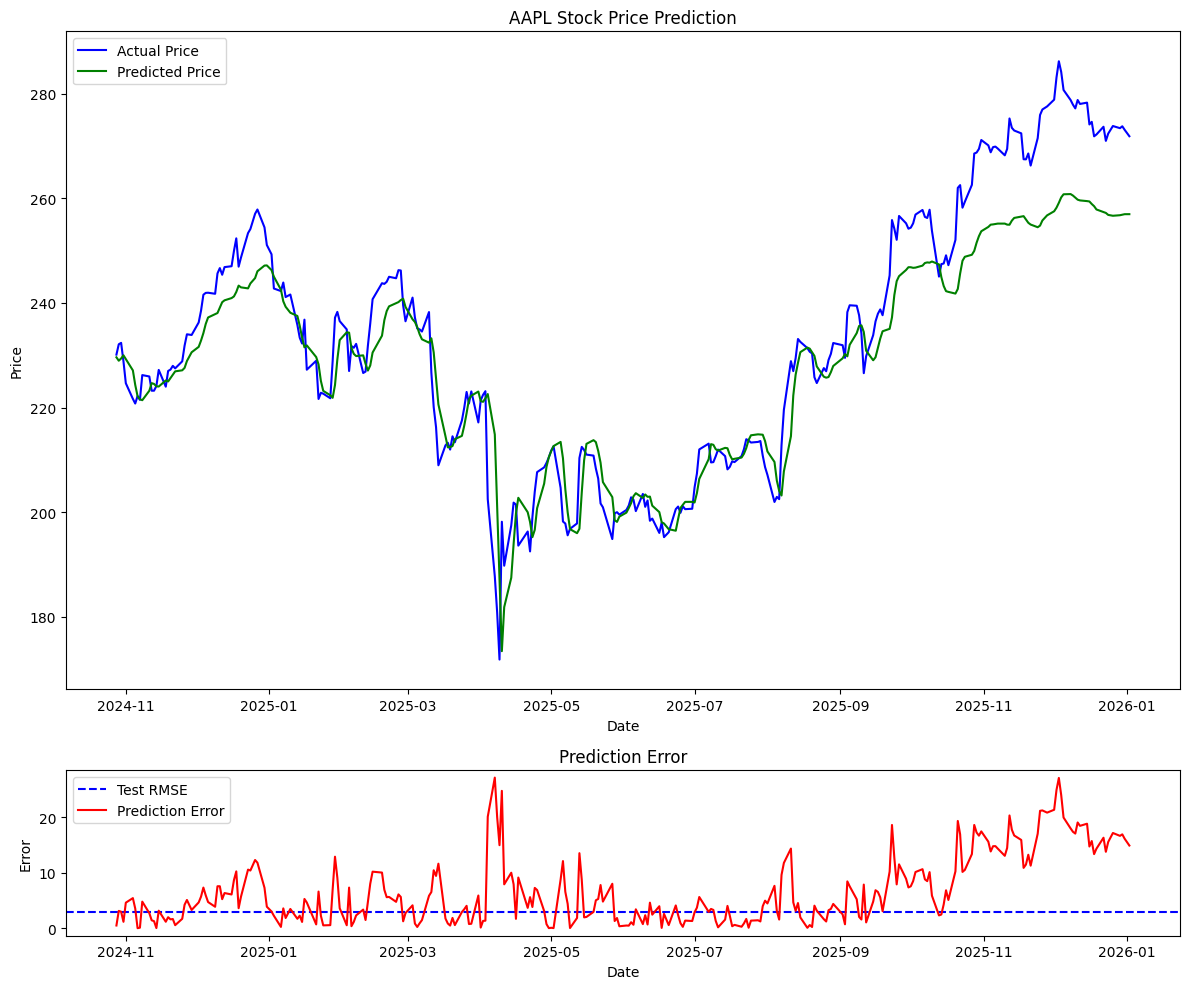

In [18]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, label='Actual Price', color='b')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, label='Predicted Price', color='g')
ax1.legend()
ax1.set_title(f'{ticker} Stock Price Prediction')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='b', linestyle='--', label='Test RMSE')
ax2.plot(df[-len(y_test):].index, np.abs(y_test - y_test_pred), label='Prediction Error', color='r')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()